### Churn Prediction

In [14]:
import kagglehub
import pandas as pd

# Download latest version
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

df = pd.read_csv('../data/processed/telco-customer-churn.csv')

#### Análise Exploratória (EDA)

##### Visualizando dataset

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


##### Colunas do dataset

In [4]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

##### Dimensões do dataset

In [5]:
df.shape

(7043, 21)

##### Tipos de dados

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


##### Estatísticas descritivas (Variáveis numéricase categoricas)

In [7]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [8]:
df.describe(include="object")

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,6531,2
top,3186-AJIEK,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,,No
freq,1,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,11,5174


##### Verificar quantos clientes saíram e quantos permaneceram

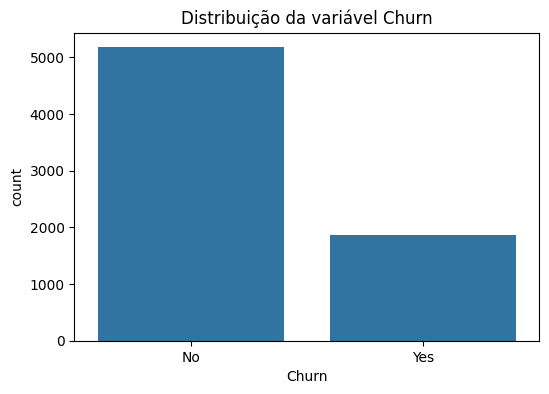

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="Churn")
plt.title("Distribuição da variável Churn")
plt.show()

##### Convertendo todas as variáveis categóricas em variáveis numéricas

In [10]:
def convert_categorical_number(df):

    df_filter = df.copy()
    
    #Desconsiderando coluna id
    df_filter = df_filter[df_filter.columns[1:]]
    
    #Filtrando apenas as colunas do tipo "object"
    columns_object = df_filter.select_dtypes(include=("object")).columns

    for col in columns_object:
        #Criando dicionário com as variáveis categóricas
        _dict = { v: k for k, v in pd.DataFrame(df[col].unique()).to_dict()[0].items()}
        df_filter[col] = df_filter[col].map(_dict)

    return df_filter

df_numerical = convert_categorical_number(df)
df_numerical.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,29.85,0,0
1,1,0,1,0,34,1,1,0,1,1,1,0,0,0,1,1,1,56.95,1,0
2,1,0,1,0,2,1,1,0,1,0,0,0,0,0,0,0,1,53.85,2,1
3,1,0,1,0,45,0,0,0,1,1,1,1,0,0,1,1,2,42.30,3,0
4,0,0,1,0,2,1,1,1,0,1,0,0,0,0,0,0,0,70.70,4,1


##### Calculando a correlação entre as variáveis

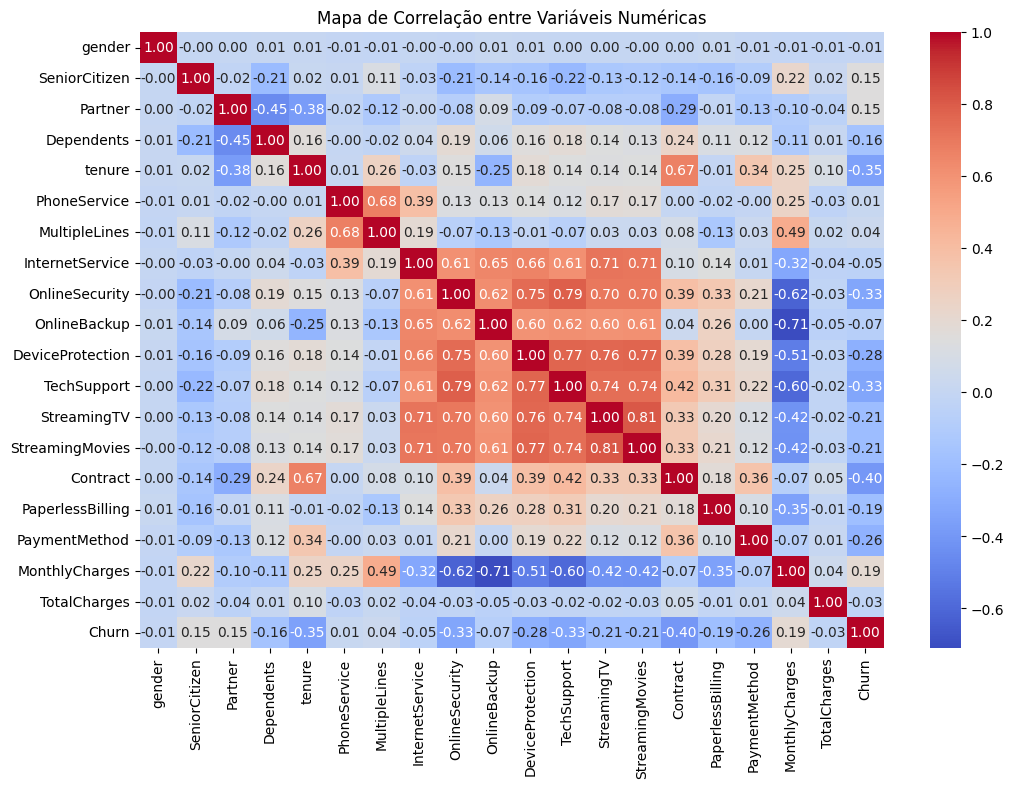

In [12]:
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(df_numerical.corr(numeric_only=True), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Mapa de Correlação entre Variáveis Numéricas')
plt.show()

In [13]:
correlation_with_target = df_numerical.corr(numeric_only=True)['Churn'].sort_values(ascending=False)
correlation_with_target

Churn               1.000000
MonthlyCharges      0.193356
SeniorCitizen       0.150889
Partner             0.150448
MultipleLines       0.036310
PhoneService        0.011942
gender             -0.008612
TotalCharges       -0.027614
InternetService    -0.047291
OnlineBackup       -0.074205
Dependents         -0.164221
PaperlessBilling   -0.191825
StreamingTV        -0.205742
StreamingMovies    -0.207256
PaymentMethod      -0.262818
DeviceProtection   -0.281465
TechSupport        -0.329852
OnlineSecurity     -0.332819
tenure             -0.352229
Contract           -0.396713
Name: Churn, dtype: float64

##### Insights gerados com relação a correção das variáveis com a vairável Churn

In [20]:
# Dados
correlacao_positiva = {
    'Variável': ['MonthlyCharges', 'SeniorCitizen', 'Partner', 'MultipleLines'],
    'Correlação': [0.193, 0.151, 0.150, 0.036],
    'Insight': [
        'Mensalidades mais altas aumentam chance de churn',
        'Idosos têm maior propensão ao churn',
        'Clientes sem parceiro tendem a sair mais',
        'Uso de múltiplas linhas tem leve associação com churn'
    ]
}

# Criação do DataFrame
df_positiva = pd.DataFrame(correlacao_positiva)
df_positiva

,Variável,Correlação,Insight
0,MonthlyCharges,0.193,Mensalidades mais altas aumentam chance de churn
1,SeniorCitizen,0.151,Idosos têm maior propensão ao churn
2,Partner,0.150,Clientes sem parceiro tendem a sair mais
3,MultipleLines,0.036,Uso de múltiplas linhas tem leve associação com churn


In [22]:
# Dados
correlacao_negativa = {
    'Variável': ['Contract', 'tenure', 'OnlineSecurity', 'TechSupport',
                 'DeviceProtection', 'PaymentMethod', 'StreamingMovies', 'StreamingTV'],
    'Correlação': [-0.397, -0.352, -0.333, -0.330, -0.281, -0.263, -0.207, -0.206],
    'Insight': [
        'Contratos longos reduzem churn',
        'Clientes antigos têm menor chance de churn',
        'Segurança online ajuda a reter clientes',
        'Suporte técnico reduz o churn',
        'Proteção de dispositivo está associada à permanência',
        'Certas formas de pagamento retêm mais',
        'Uso de streaming de filmes ajuda a manter clientes',
        'Uso de streaming de TV ajuda a manter clientes'
    ]
}

# Criação do DataFrame
df_negativa = pd.DataFrame(correlacao_negativa)
df_negativa


,Variável,Correlação,Insight
0,Contract,-0.397,Contratos longos reduzem churn
1,tenure,-0.352,Clientes antigos têm menor chance de churn
2,OnlineSecurity,-0.333,Segurança online ajuda a reter clientes
3,TechSupport,-0.330,Suporte técnico reduz o churn
4,DeviceProtection,-0.281,Proteção de dispositivo está associada à permanência
5,PaymentMethod,-0.263,Certas formas de pagamento retêm mais
6,StreamingMovies,-0.207,Uso de streaming de filmes ajuda a manter clientes
7,StreamingTV,-0.206,Uso de streaming de TV ajuda a manter clientes


##### Analisando comportamento de clientes que saíram (Churn = 1) com as variáveis: 

    tenure (tempo de contrato)

    MonthlyCharges (valor mensal)

    Contract, PaymentMethod, InternetService (categorias)

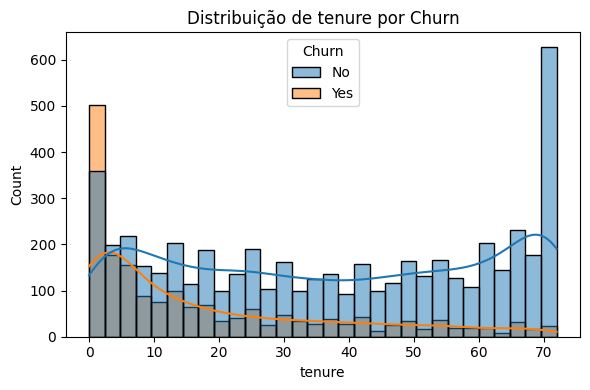

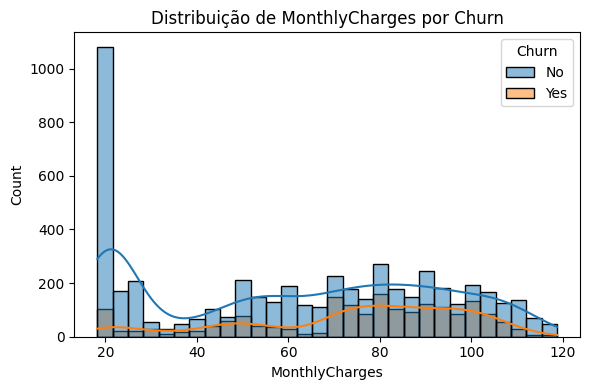

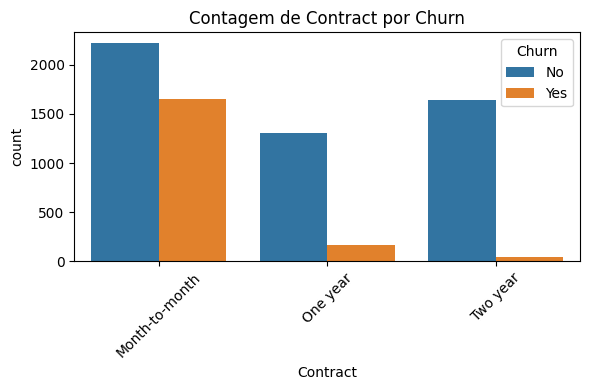

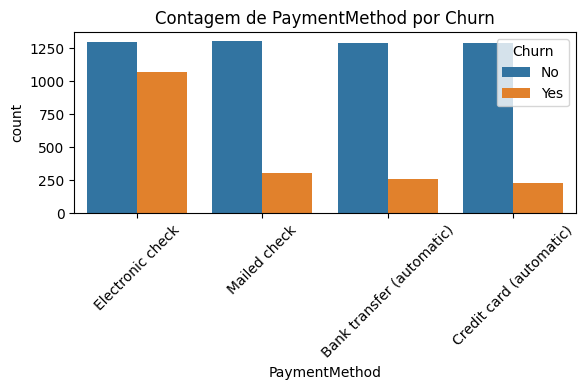

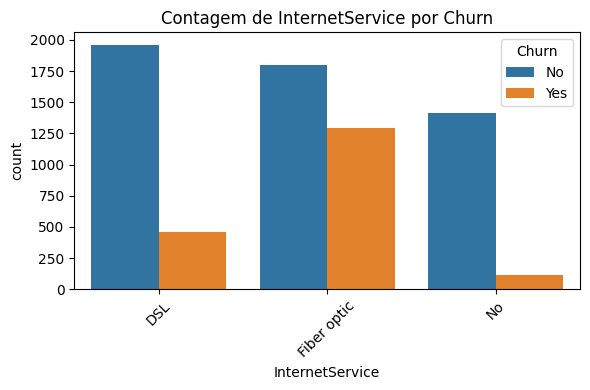

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Lista de variáveis que queremos analisar
variaveis_para_analisar = ['tenure', 'MonthlyCharges',
                           'Contract', 'PaymentMethod', 'InternetService']


for var in variaveis_para_analisar:
    plt.figure(figsize=(6, 4))
    
    if df[var].dtype in ['int64', 'float64']:  # Variável numérica
        sns.histplot(data=df, x=var, hue='Churn', kde=True, bins=30)
        plt.title(f'Distribuição de {var} por Churn')
        
    else:  # Variável categórica
        sns.countplot(data=df, x=var, hue='Churn')
        plt.title(f'Contagem de {var} por Churn')
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

##### Realizando balanceamento das classes